In [12]:
import pandas as pd
import numpy as np

def get_results_df(CHECKPOINT, DISTANCE, DATASET):
    results_df = pd.read_csv(f"outputs/cscs_CP{CHECKPOINT}_{DISTANCE}/cscs_values_{DATASET}.csv")
    results_df.rename(columns={'semantic_change': 'sc'}, inplace=True)
    results_df.rename(columns={'grammaticality': 'sp'}, inplace=True)
    results_df.rename(columns={'perplexity': 'pp'}, inplace=True)
    results_df.rename(columns={'sentence': 'sequence'}, inplace=True)
    results_df["ip"] = 1 / results_df["pp"]
    results_df["gr"] = (results_df["sp"] + results_df["ip"]) / 2
    results_df["log10(sc)"] = np.log10(results_df["sc"])
    results_df["log10(sp)"] = np.log10(results_df["sp"])
    results_df["log10(ip)"] = np.log10(results_df["ip"])
    results_df['log10(gr)'] = np.log10(results_df['gr'])

    return results_df

def rank_results_df(results_df):
    # add rank_by_sc, rank_by_sp and rank_by_ip
    results_df["rank_by_sc"] = results_df["sc"].rank(ascending=False)
    results_df["rank_by_sp"] = results_df["sp"].rank(ascending=False)
    results_df["rank_by_ip"] = results_df["ip"].rank(ascending=False)
    results_df["rank_by_gr"] = results_df["gr"].rank(ascending=False)

    # make ranks integers
    results_df["rank_by_sc"] = results_df["rank_by_sc"].astype(int)
    results_df["rank_by_sp"] = results_df["rank_by_sp"].astype(int)
    results_df["rank_by_ip"] = results_df["rank_by_ip"].astype(int)
    results_df["rank_by_gr"] = results_df["rank_by_gr"].astype(int)

    # add rank_by_sc_sp, rank_by_sc_ip, and rank_by_sc_gr by adding the ranks of sc and sp/ip/gr
    results_df["rank_by_scsp"] = results_df["rank_by_sc"] + results_df["rank_by_sp"]
    results_df["rank_by_scip"] = results_df["rank_by_sc"] + results_df["rank_by_ip"]
    results_df["rank_by_scgr"] = results_df["rank_by_sc"] + results_df["rank_by_gr"]

    # By default sort by rank_by_sc_gr
    results_df = results_df.sort_values(by="rank_by_scgr")
    return results_df

In [200]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

def remove_outliers(df, column):
    """
    Remove outliers from a DataFrame column using the IQR method.
    """
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

def draw(CHECKPOINT, DISTANCE, GPT_TEMP):
    # Overall title
    if CHECKPOINT == "X":
        TITLE = "CoV-RoBERTa without Contrastive Learning"
    elif CHECKPOINT == "4":
        TITLE = "CoV-SNN Transformer with Best Zero-shot Accuracy"
    elif CHECKPOINT == "0":
        TITLE = "CoV-SNN Transformer with Best Test Accuracy"

    # Reading the data
    df_eris_cscs = get_results_df(CHECKPOINT, DISTANCE, "eris")
    df_new_cscs = get_results_df(CHECKPOINT, DISTANCE, "new")
    dfs_gpt_cscs = []
    for temp in GPT_TEMP:
        dfs_gpt_cscs.append(get_results_df(CHECKPOINT, DISTANCE, f"GPT_{temp}"))

    df_eris_cscs = remove_outliers(df_eris_cscs, 'sc')
    df_new_cscs = remove_outliers(df_new_cscs, 'sc')
    for i in range(len(GPT_TEMP)):
        dfs_gpt_cscs[i] = remove_outliers(dfs_gpt_cscs[i], 'sc')

    # Combine the three DataFrames into one for easier plotting
    df_combined = pd.concat([
        df_eris_cscs.assign(source='Eris'),
        df_new_cscs.assign(source='New')
    ])
    for i, temp in enumerate(GPT_TEMP):
        df_combined = pd.concat([
            df_combined,
            dfs_gpt_cscs[i].assign(source=f'GPT$_{{{temp}}}$')
        ])

    df_combined = rank_results_df(df_combined)

    # Convert rank values to percentages if needed
    df_combined['rank_by_scsp'] = (df_combined['rank_by_scsp'] / df_combined['rank_by_scsp'].max()) * 100
    df_combined['rank_by_scip'] = (df_combined['rank_by_scip'] / df_combined['rank_by_scip'].max()) * 100

    # Plotting the boxplots using seaborn
    sns.set_theme(style="whitegrid", font_scale=1.3)
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    sns.boxplot(
        data=df_combined,
        x='source',
        y='rank_by_scsp',
        width=0.75,
        ax=axes[0],
        showfliers=True
    )
    sns.set_style("white")
    axes[0].set_title('R\' = rank(SC) + rank(SP)')
    axes[0].set_xlabel('')
    axes[0].set_ylabel('Ranked in Top (%)')
    axes[0].yaxis.set_major_formatter(mticker.PercentFormatter())
    axes[0].set_ylim(-5, 105)  # Set consistent spacing for 0% and 100%

    sns.boxplot(
        data=df_combined,
        x='source',
        y='rank_by_scip',
        ax=axes[1],
        width=0.75,
        showfliers=True
    )
    sns.set_style("white")
    axes[1].set_title('R\' = rank(SC) + rank(IP)')
    axes[1].set_xlabel('')
    axes[1].set_ylabel('Ranked in Top (%)')
    axes[1].yaxis.set_major_formatter(mticker.PercentFormatter())
    axes[1].set_ylim(-5, 105)  # Set consistent spacing for 0% and 100%

    # hide gridlines
    axes[0].grid(False)
    axes[1].grid(False)

    fig.suptitle(TITLE, fontsize=16)
    plt.tight_layout()
    
    fig_file_name = f"figures/cscs_box_CP{CHECKPOINT}_{DISTANCE}.pdf"
    plt.savefig(fig_file_name)
    plt.show()


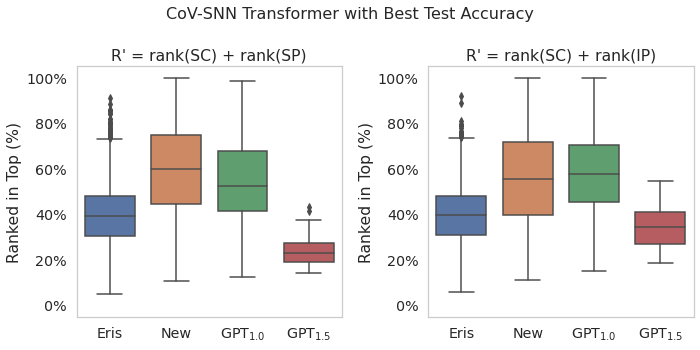

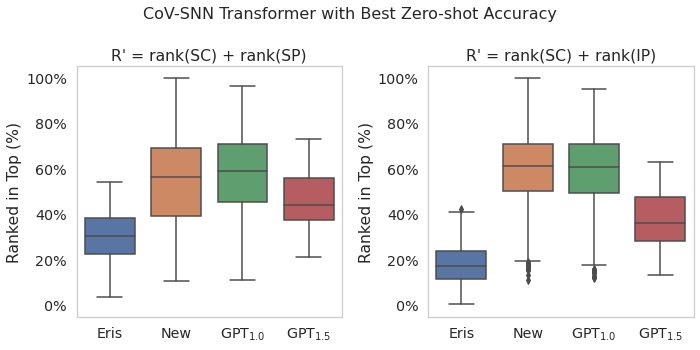

In [201]:
draw(CHECKPOINT="0", DISTANCE="L2", GPT_TEMP=["1.0", "1.5"])
draw(CHECKPOINT="4", DISTANCE="L2", GPT_TEMP=["1.0", "1.5"])